In [1]:
import os
import time
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
from datetime import datetime

from IPython.display import display, HTML
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split

%load_ext autoreload
%autoreload 2

import plotly.io as pio
pio.renderers.default = 'iframe'

In [2]:
## Local Utils File
from utils.eda import *
from utils.kanhon_utils import *
from utils.melissa_imputers import *
from utils.melissa_utils import *
from utils.Bhushan_utils import *
from utils.lta_omv_scraper import *
from utils.models import Regression

## Feature Processing

### Test Data preview

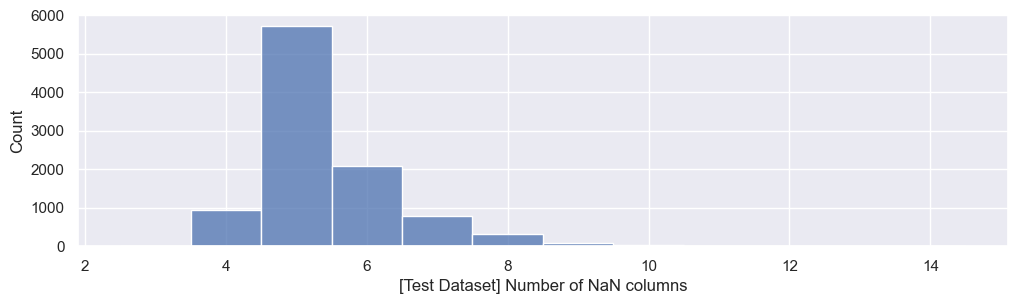

In [3]:
test_df = pd.read_csv(r"./dataset/test.csv")
test_df['model'] = test_df['model'].apply(lambda x:x.replace('(', ''))
test_df['reg_date_dt'] = test_df['reg_date'].apply(lambda x: datetime.strptime(x, "%d-%b-%Y"))
test_df['reg_date_year'] = test_df['reg_date_dt'].apply(lambda x:x.year)
test_df['reg_date_month'] = test_df['reg_date_dt'].apply(lambda x:x.month)

plt.rcParams['figure.figsize'] = (12, 3)
sns.set()

number_nans = test_df.apply(lambda row: sum(map(isnan, row)), axis=1)
sns.histplot(number_nans, discrete=True)
plt.xlabel('[Test Dataset] Number of NaN columns')
plt.show()

### Read and clean dataset

In [4]:
orig_df = pd.read_csv(r"./dataset/train.csv")

# clean model
orig_df['model'] = orig_df['model'].apply(lambda x:x.replace('(', ''))
orig_df['reg_date_dt'] = orig_df['reg_date'].apply(lambda x: datetime.strptime(x, "%d-%b-%Y"))
orig_df['reg_date_year'] = orig_df['reg_date_dt'].apply(lambda x:x.year)
orig_df['reg_date_month'] = orig_df['reg_date_dt'].apply(lambda x:x.month)

# Adding additional feature for imputation later
# train_df["model_make"] = train_df.model + "_" + train_df.make

General overview of Nan Columns

In [5]:
## Split into train val split
train_df, val_df = train_test_split(orig_df, test_size=0.2, random_state=42, shuffle=True)

### Fill missing 'make' info from title

In [6]:
make_df = pd.read_csv(r"./dataset/make.csv")
make_ls = [make.lower() for make in make_df['Make List'].unique()]

In [7]:
make_model_imputer = MakeModelImputer(make_ls)

train_df = make_model_imputer.transform(train_df)
val_df = make_model_imputer.transform(val_df) 
test_df = make_model_imputer.transform(test_df) 

In [8]:
# Generating model make imputer
train_df["model_make"] = train_df.model + "_" + train_df.make
val_df["model_make"] = val_df.model + "_" + val_df.make
test_df["model_make"] = test_df.model + "_" + test_df.make

### type_of_vehicle

In [9]:
# For each model and make check the type of vehicles count
unique_list = display_feature_dist_by_ref_col(df=train_df,feature="type_of_vehicle",ref="model_make")
make_models_with_diff_bodies = list()
for key, value in unique_list.items():
    if len(value) >= 2:
        make_models_with_diff_bodies.append(key)

Number of model_make unable to be inputted 0


In [10]:
# Assuming you have a DataFrame 'train_df' with columns 'type_of_vehicle' and 'price'
fig = px.box(train_df, x="type_of_vehicle", y='price', points="all")

# Update the layout to make the x-axis labels horizontal
fig.update_layout(xaxis_tickangle=0)

# Show the figure
fig.show()

In [11]:
# Assuming you have a DataFrame 'train_df' with columns 'type_of_vehicle' and 'price'
fig = px.scatter(train_df, x="omv", y='price', color="type_of_vehicle",trendline="ols")

# Show the figure
fig.show()

In [12]:
## Processing 
train_df , vehicle_type_encoder = vehicle_type_fit_transform(train_df, "type_of_vehicle")
val_df = vehicle_type_fit(val_df, vehicle_type_encoder)
test_df = vehicle_type_fit(test_df, vehicle_type_encoder)

### curb_weight

In [13]:
# Superceeded # display(HTML(train_df.head(50).to_html()))
def fill_column_b_with_mean(df, column_a, column_b):
    # Calculate the mean of column B grouped by column A
    values = df.groupby(column_a)[column_b].agg(["mean"]).rename(columns={"mean": column_b})[column_b]
    
    # Iterate over each row in the DataFrame
    for index, row in df.iterrows():
        # If column B is NaN, fill it with the mean value of column B for the corresponding value in column A
        if pd.isna(row[column_b]):
            df.at[index, column_b] = values[row[column_a]]
    return df

In [14]:
curb_weight_impute = ModelMakeImputer(column_a="model_make", column_b="curb_weight")

train_df = curb_weight_impute.fit_transform(train_df) # 82 rows missing
val_df = curb_weight_impute.transform(val_df) # 20 rows missing
test_df = curb_weight_impute.transform(test_df) # 40 rows missing

# Many rows are missing, impute using median values
imputer = SimpleImputer(strategy='median')
train_df['curb_weight'] = imputer.fit_transform(train_df[['curb_weight']])
val_df['curb_weight'] = imputer.transform(val_df[['curb_weight']])
test_df['curb_weight'] = imputer.transform(test_df[['curb_weight']])

### power 

In [15]:
power_impute = ModelMakeImputer(column_a="model_make", column_b="power")

train_df = power_impute.fit_transform(train_df) # 1537 rows missing
val_df = power_impute.transform(val_df) # 379 rows missing
test_df = power_impute.transform(test_df) # 789 rows missing

# Many rows are missing, impute using median values
imputer = SimpleImputer(strategy='median')
train_df['power'] = imputer.fit_transform(train_df[['power']])
val_df['power'] = imputer.transform(val_df[['power']])
test_df['power'] = imputer.transform(test_df[['power']])

### engine_cap 

In [16]:
engine_impute = ModelMakeImputer(column_a="model_make", column_b="engine_cap")

train_df = engine_impute.fit_transform(train_df) # 384 rows missing
val_df = engine_impute.transform(val_df) # 97 rows missing
test_df = engine_impute.transform(test_df) # 186 rows missing

# Many rows are missing, impute using median values
imputer = SimpleImputer(strategy='median')
train_df['engine_cap'] = imputer.fit_transform(train_df[['engine_cap']])
val_df['engine_cap'] = imputer.transform(val_df[['engine_cap']])
test_df['engine_cap'] = imputer.transform(test_df[['engine_cap']])

### no_of_owners

In [17]:
## New method
display(f' Before imputation : {train_df["no_of_owners"].isna().sum()}')

owner_impute = OwnerImputer()

train_df = owner_impute.fit_transform(df=train_df)
val_df = owner_impute.transform(val_df)
test_df = owner_impute.transform(test_df)
display(f' After imputation : {train_df["no_of_owners"].isna().sum()}')

' Before imputation : 11'

19989
[Number of months per owner]  ->  [mean = 49.10992045625093, median = 41.666666666666664, mode = 29.0]


' After imputation : 0'

### Manufactured

In [18]:
# Manufactured

train_df['effective_reg_date'] = train_df['original_reg_date'].fillna(train_df['reg_date'])
train_df = train_df.drop(columns=['original_reg_date'])

train_df['effective_reg_date'] = pd.to_datetime(train_df['effective_reg_date'], errors='coerce', format='%d-%b-%Y')
train_df['manufactured'] = train_df['manufactured'].fillna(train_df['effective_reg_date'].dt.year)

val_df['effective_reg_date'] = val_df['original_reg_date'].fillna(val_df['reg_date'])
val_df = val_df.drop(columns=['original_reg_date'])

val_df['effective_reg_date'] = pd.to_datetime(val_df['effective_reg_date'], errors='coerce', format='%d-%b-%Y')
val_df['manufactured'] = val_df['manufactured'].fillna(val_df['effective_reg_date'].dt.year)

test_df['effective_reg_date'] = test_df['original_reg_date'].fillna(test_df['reg_date'])
test_df = test_df.drop(columns=['original_reg_date'])

test_df['effective_reg_date'] = pd.to_datetime(test_df['effective_reg_date'], errors='coerce', format='%d-%b-%Y')
test_df['manufactured'] = test_df['manufactured'].fillna(test_df['effective_reg_date'].dt.year)

In [19]:
# Car age

train_df = calc_vehicle_age(train_df)
val_df = calc_vehicle_age(val_df)
test_df = calc_vehicle_age(test_df)

### depreciation 

In [20]:
# Imputation using make, model and car age - Dependency on 'car_age'
depreciation_imputer = DepreciationImputer()
train_df = depreciation_imputer.fit_transform(train_df) # 96 empty records
val_df = depreciation_imputer.transform(val_df) # 9 empty records

# Median imputation for remaining records
imputer = SimpleImputer(strategy='median')
train_df['depreciation'] = imputer.fit_transform(train_df[['depreciation']])
val_df['depreciation'] = imputer.transform(val_df[['depreciation']])
test_df['depreciation'] = imputer.transform(test_df[['depreciation']])

### Transmission

In [21]:
# Transmission

# One-hot encoding
train_df = pd.get_dummies(train_df, columns=['transmission'], prefix='transmission')
train_df.drop('transmission_manual', axis=1, inplace=True)

unique_transmissions = train_df['transmission_auto'].unique()
transmission_counts = train_df['transmission_auto'].value_counts()
print(unique_transmissions, transmission_counts)

[ True False] transmission_auto
True     18660
False     1340
Name: count, dtype: int64


### dereg_value

### mileage   

In [22]:
display(f' Before imputation : {train_df["mileage"].isna().sum()}')
## New method

mileage_impute = mileageImputer()

train_df = mileage_impute.fit_transform(df=train_df)
val_df = mileage_impute.transform(val_df)
test_df = mileage_impute.transform(test_df)

display(f' After imputation : {train_df["mileage"].isna().sum()}')

' Before imputation : 4248'

[Miles per month]  ->  [mean = 991.4079634320296, median = 965.602776533811, mode = 1000.0]


' After imputation : 0'

### omv 

In [23]:
csv_filename = r'./dataset/lta_omv_data.csv'

if os.path.exists(csv_filename):
    df_lta_car_data = pd.read_csv(csv_filename)
else:
    result_ls = get_lta_omv_data(2002, 2025)
    df_lta_car_data = preprocess_lta_omv_data(result_ls)
    df_lta_car_data.to_csv(csv_filename)

lta_data_imputer = LTADataImputer(df_lta_car_data)

train_df = lta_data_imputer.transform(train_df) # before transform: 49 rows missing, after transform: 24 rows missing
val_df = lta_data_imputer.transform(val_df) # before transform: 15 rows missing, after transform: 9 rows missing
test_df = lta_data_imputer.transform(test_df) 

imputer = SimpleImputer(strategy='median')
train_df['omv'] = imputer.fit_transform(train_df[['omv']])
val_df['omv'] = imputer.transform(val_df[['omv']])
test_df['omv'] = imputer.transform(test_df[['omv']])

In [24]:
# Superceeded code
def impute_using_lta_data(row):
    # print(row)
    if not np.isnan(row['omv']):
        return row['omv']
    else:
        make = row['make']
        model = row['model']
        year = row['reg_date_year']
        lookup_by_make_model_year = df_lta_car_data[(df_lta_car_data['make_clean'] == make) & (df_lta_car_data['model_split'].str.contains(model)) & (df_lta_car_data['year'] == year)]
        
        lookup_by_make_model = df_lta_car_data[(df_lta_car_data['make_clean'] == make) & (df_lta_car_data['model_split'].str.contains(model))]

        lookup_by_make = df_lta_car_data[(df_lta_car_data['make_clean'] == make)]
        
        if not lookup_by_make_model_year.empty:
            # print('lookup_by_make_model_year')
            return lookup_by_make_model_year['omv_clean'].mean()
        elif not lookup_by_make_model.empty:
            # print('lookup_by_make_model')
            return lookup_by_make_model['omv_clean'].mean()
        elif not lookup_by_make.empty:
            # print('lookup_by_make')
            return lookup_by_make['omv_clean'].mean()
        else: 
            return None

# train_df['omv_new'] = train_df['omv']
# train_df['omv_new'] = train_df.apply(impute_using_lta_data, axis=1)
# train_df['omv_new'] = train_df['omv_new'].fillna(train_df['omv_new'].mean())

# train_df.info()

### Lifespan

In [ ]:
display(f' Before imputation : {train_df["lifespan"].isna().sum()}')

# Functional Form
impute_lifespan(train_df)

display(f' After imputation : {train_df["lifespan"].isna().sum()}')

### Fuel Type

In [25]:
# Assuming you have a DataFrame 'train_df' with columns 'type_of_vehicle' and 'price'
fig = px.box(train_df, x="fuel_type", y='price', points="all")

# Update the layout to make the x-axis labels horizontal
fig.update_layout(xaxis_tickangle=0)

# Show the figure
fig.show()

In [26]:
get_fuel_type(train_df)

Original Imputation Nan 15339
After Imputation Nan 14397


,listing_id,title,make,model,description,manufactured,reg_date,type_of_vehicle,category,curb_weight,...,type_of_vehicle_mpv,type_of_vehicle_others,type_of_vehicle_sports car,type_of_vehicle_stationwagon,type_of_vehicle_suv,type_of_vehicle_truck,type_of_vehicle_van,effective_reg_date,car_age,transmission_auto
0,1260733,Isuzu NPR85,isuzu,npr85,cheapest in the market! 14 feet full canopy wi...,2019.0,01-jul-2020,truck,premium ad car,2500.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2020-07-01,5.0,True
1,1289505,Honda Fit 1.3A G (COE till 06/2024),honda,fit,200,2009.0,12-aug-2009,hatchback,coe car,1010.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2009-08-12,15.0,True
2,1316182,Toyota Sienta 1.5A,toyota,sienta,non phv. excellent condition. 100% accident fr...,2018.0,28-may-2018,mpv,"parf car, premium ad car",1325.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2018-05-28,6.0,True
3,1310514,Volvo V40 T4 Momentum,volvo,v40,"well maintained! the safety, reliable and dura...",2018.0,30-aug-2019,hatchback,parf car,1441.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019-08-30,6.0,True
4,1247893,Kia Carens 2.0A GDI,kia,carens,rare 1 owner unit! low km done! fully maintain...,2015.0,18-nov-2015,mpv,parf car,1544.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2015-11-18,9.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,1330095,BMW 3 Series 318i,bmw,318i,0,2015.0,26-feb-2016,luxury sedan,"parf car, consignment car, sgcarmart warranty ...",1425.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2016-02-26,9.0,True
19996,1300273,Nissan Qashqai 1.2A DIG-T,nissan,qashqai,"no repairs needed, buy and drive as it is! one...",2016.0,17-jun-2016,suv,"parf car, premium ad car",1285.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2016-06-17,8.0,True
19997,1316903,Honda Jazz 1.3A,honda,jazz,"1 owner, maintain by honda kah motor, at dicks...",2019.0,10-jul-2019,hatchback,parf car,1052.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019-07-10,5.0,True
19998,1329593,Ferrari 488 GTB,ferrari,488,ital unit with warranty till dec 2024. fully s...,2016.0,03-nov-2016,sports car,"parf car, direct owner sale, rare & exotic, lo...",1515.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2016-11-03,8.0,True


### Cylinder Count

In [27]:
cylinder_count_extractor = CylinderExtractor()

train_df = cylinder_count_extractor.transform(train_df)
val_df = cylinder_count_extractor.transform(val_df) 
test_df = cylinder_count_extractor.transform(test_df) 

In [28]:
cylinder_imputer = CylinderImputer()
train_df = cylinder_imputer.fit_transform(train_df) # 1479 rows missing
val_df = cylinder_imputer.transform(val_df) # 334 rows missing
test_df = cylinder_imputer.transform(test_df)

# Many rows are missing, impute using median values
imputer = SimpleImputer(strategy='median')
train_df['cylinder_cnt'] = imputer.fit_transform(train_df[['cylinder_cnt']])
val_df['cylinder_cnt'] = imputer.transform(val_df[['cylinder_cnt']])
test_df['cylinder_cnt'] = imputer.transform(test_df[['cylinder_cnt']])

### Category Parser

In [29]:
category_parser = CategoryParser()
train_df = category_parser.fit_transform(train_df) 
val_df = category_parser.transform(val_df) 

### features 

In [30]:
train_df['cylinder_cnt'] = train_df['features'].apply(lambda x: extract_cylinder_from_features(x) if pd.notnull(x) else None)
cylinder_count_dict = extract_cylinder_by_model_make(train_df)
train_df['cylinder_cnt'] = train_df.apply(lambda x:impute_row_by_make_model(x, cylinder_count_dict, 'cylinder_cnt'), axis=1)
# fill remaining values with median of 4 cylinder (most common engine)
median_cylinder_cnt = train_df['cylinder_cnt'].median(axis=0)
train_df['cylinder_cnt'] = train_df['cylinder_cnt'].fillna(median_cylinder_cnt)

## Transformation

In [31]:
# Yeo-Johnson transformation
YJ_features = ['curb_weight', 'power', 'cylinder_cnt', 'omv', 'engine_cap', 'depreciation', 'mileage', 'coe', 'car_age', 'manufactured']
train_df = transform_YeoJohnson(train_df, YJ_features)
val_df = transform_YeoJohnson(val_df, YJ_features)

C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\_core\_methods.py:197: RuntimeWarning:

overflow encountered in multiply

C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\_core\_methods.py:208: RuntimeWarning:

overflow encountered in reduce

C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\_core\_methods.py:197: RuntimeWarning:

overflow encountered in multiply

C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\_core\_methods.py:208: RuntimeWarning:

overflow encountered in reduce



In [32]:
# Box-Cox Transformation
BC_features = ['no_of_owners']
train_df = transform_BoxCox(train_df, BC_features)
val_df = transform_BoxCox(val_df, BC_features)

## Transformation comparison

In [31]:
features = ['curb_weight', 'power', 'cylinder_cnt', 'omv', 'engine_cap', 'depreciation', 'mileage', 'no_of_owners', 'coe', 'car_age', 'manufactured']

In [32]:
from scipy.stats import boxcox, skew
from sklearn.preprocessing import PowerTransformer
import matplotlib.pyplot as plt

train_df['data_type'] = 'train'
test_df['data_type'] = 'test'
combined_df = pd.concat([train_df, test_df], ignore_index=True)

def apply_transformations(feature_values):
    transformations = {}
    transformations['original'] = feature_values
    # Log Transformation (only for positive values)
    if (feature_values > 0).all():
        transformations['Log'] = np.log1p(feature_values)
    else:
        transformations['Log'] = None
    # Square-root Transformation
    transformations['Square Root'] = np.sqrt(feature_values.clip(0))
    # Box-Cox Transformation (only for positive values)
    if (feature_values > 0).all():
        transformations['Box-Cox'], _ = boxcox(feature_values + 1e-6)
    else:
        transformations['Box-Cox'] = None
    # Yeo-Johnson Transformation
    yeo_johnson = PowerTransformer(method='yeo-johnson')
    transformations['Yeo-Johnson'] = yeo_johnson.fit_transform(feature_values.values.reshape(-1, 1)).flatten()
    return transformations

In [ ]:
num_cols = 5  # Number of columns for subplots
for feature in features:
    transformations = {}
    transformations.update(apply_transformations(combined_df[feature]))
    
    # Prepare plots
    fig, axes = plt.subplots(1, num_cols, figsize=(20, 5), constrained_layout=True)
    fig.suptitle(f'Transformation Comparison for Feature: {feature}', fontsize=16)

    for idx, (transform_name, transformed_values) in enumerate(transformations.items()):
        ax = axes[idx]
        if transformed_values is not None:
            plot_data = pd.DataFrame({
                feature: transformed_values,
                'data_type': combined_df['data_type']
            })
            
            ax = axes[idx]
            sns.histplot(data=plot_data, x=feature, hue='data_type', bins=30, kde=True,
                         element='step', ax=ax, alpha=0.7)
            # Calculate skewness
            skew_val = skew(transformed_values)
            ax.set_title(f'{transform_name}\nSkew: {skew_val:.2f}', fontsize=12)
            ax.set_xlabel('Value')
            ax.set_ylabel('Frequency')
        else:
            ax.set_visible(False)
            ax.set_title(f'{transform_name} (Not Applicable)', fontsize=12)

    plt.show()

## Data normalization

In [ ]:
display(HTML(train_df.head(5).to_html()))

In [52]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from utils.models import Classification
from sklearn.impute import SimpleImputer


In [57]:

features = ['curb_weight_impute', 'power_impute', 'cylinder_cnt', 'omv_new',
       'engine_cap_impute', 'depreciation', 'mileage', 'dereg_value']

X_train, X_test, y_train, y_test = train_test_split(train_df[features], train_df['price'], test_size=0.3, random_state=42)


In [58]:
scaler = MinMaxScaler()
imputer = SimpleImputer(strategy='median')
imputer.fit(X_train[features])

X_train[features] = imputer.transform(X_train[features])
X_test[features] = imputer.transform(X_test[features])

# Fit and transform the numerical columns
X_train[features] = scaler.fit_transform(X_train[features])
X_test[features] = scaler.transform(X_test[features])

In [ ]:
X_train[features].info()

## Training models

In [ ]:
train_df.lifespan

In [ ]:
# display(HTML(train_df.head(50).to_html()))
features = ['curb_weight', 'power', 'cylinder_cnt', 'omv',
       'engine_cap', 'depreciation', 'mileage', 'no_of_owners','type_of_vehicle_bus/mini bus', 'type_of_vehicle_hatchback',
       'type_of_vehicle_luxury sedan', 'type_of_vehicle_mid-sized sedan',
       'type_of_vehicle_mpv', 'type_of_vehicle_others',
       'type_of_vehicle_sports car', 'type_of_vehicle_stationwagon',
       'type_of_vehicle_suv', 'type_of_vehicle_truck', 'type_of_vehicle_van']

train_df[features].isna().sum()

In [37]:
# Scale dataset
scaler = MinMaxScaler()
imputer = SimpleImputer(strategy='median')

imputer.fit(train_df[features])

# Split data into training and test sets
train_df[features] = imputer.transform(train_df[features])
val_df[features] = imputer.transform(val_df[features])
test_df[features] = imputer.transform(test_df[features])

# Fit and transform the numerical columns
train_df[features] = scaler.fit_transform(train_df[features])
val_df[features] = scaler.transform(val_df[features])
test_df[features] = scaler.transform(test_df[features])

In [39]:
X_train = train_df[features]
y_train = train_df['price']

X_val = val_df[features]
y_val = val_df['price']

In [ ]:
# 2. Initialize the Regression class
regressor = Regression()

# 3. Define parameters for hyperparameter tuning
params = {
    'n_estimators': [10, 50, 100],
    'max_depth': [ 1, 10, 20],
    'min_samples_split': [2, 5, 10]
}


# Example for Random Forest with accuracy scoring and KFold validation
tuner, best_params, tuner_results = regressor.hyperparameter_tuning(
    df_tuple=(X_train, y_train),   # The training data (X, y)
    score_metric='neg_root_mean_squared_error',       # Scoring metric
    kfold_type='kfold',            # Type of fold (KFold used here)
    n_splits=5,                    # Number of splits for KFold
    params=params,                 # Hyperparameter grid to search
    model_name='random_forest'      # Model to use (Random Forest in this case)
)

# 4. View the best hyperparameters and fit the model
print(f"Best Parameters: {best_params}")

# 5. Use the best model to predict on the test set
best_model = tuner.best_estimator_


In [ ]:
import joblib

# Save model 
model_name = "random_forest_v3"
save_path = f"./model_assets"
# Save the trained model
joblib.dump(best_model, f"{save_path}/{model_name}.joblib")

In [44]:
import joblib
import plotly.express as px
import plotly.graph_objects as go

def _infer_type(data) -> np.ndarray:

    ## type checker

    try:
        assert type(data) == np.ndarray, "incorrect type"

    except AssertionError:
        data = data.to_numpy()
        print("INFO [_infer_type] :: Type changed")
        return data

    else:
        return data

def mini_reg_evaluate(
    df_train_tuple: tuple, df_valid_tuple: tuple, model_name: str, save_path:str
):

    model = joblib.load(f"{save_path}/{model_name}.joblib")
    X_train, y_train = df_train_tuple[0], df_train_tuple[1]
    X_valid, y_valid = df_valid_tuple[0], df_valid_tuple[1]

    ## type checker

    X_train = _infer_type(X_train)
    y_train = _infer_type(y_train)
    X_valid = _infer_type(X_valid)
    y_valid = _infer_type(y_valid)

    # Train and validation scores
    y_train_pred = model.predict(X_train)
    y_valid_pred = model.predict(X_valid)
    
    # Visualize scatter plot for validation data
    plt.scatter(y_valid, y_valid_pred, color='blue', alpha=0.5)
    plt.plot([y_valid.min(), y_valid.max()], [y_valid.min(), y_valid.max()], color='red', linestyle='--')
    plt.title("y_valid predicted vs actual")
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)
    plt.show()
    
    # Visualize scatter plot for training data
    plt.scatter(y_train, y_train_pred, color='blue', alpha=0.5)
    plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], color='red', linestyle='--')
    plt.title("y_train predicted vs actual")
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)
    plt.show()
    
    # Visualize residual plot
    plt.scatter(y_valid_pred, y_valid_pred - y_valid, color='blue', alpha=0.5)
    plt.plot([y_valid_pred.min(), y_valid_pred.max()], [0, 0], color='red', linestyle='--')
    plt.title("Residual Plot (Validation Data)")
    plt.xlabel("Predicted Values")
    plt.ylabel("Residual Values")
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)
    plt.show()
    
    plt.scatter(y_train_pred, y_train_pred - y_train, color='blue', alpha=0.5)
    plt.plot([y_train_pred.min(), y_train_pred.max()], [0, 0], color='red', linestyle='--')
    plt.title("Residual Plot (Training Data)")
    plt.xlabel("Predicted Values")
    plt.ylabel("Residual Values")
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)
    plt.show()
  

In [ ]:
model_name = "random_forest_v3"
save_path = f"./model_assets"

mini_reg_evaluate(df_train_tuple=(X_train, y_train),
df_valid_tuple=( X_val,y_val),model_name=model_name, save_path=save_path)

In [ ]:
## Retrain the model
# Train + Valid (Retrain on the whole model)

In [ ]:
model = joblib.load(f"{save_path}/{model_name}.joblib")
X_test = _infer_type(test_df[features])
y_test_pred = model.predict(X_test)
submission = pd.DataFrame(y_test_pred).reset_index().rename(columns={"index":"Id", 0:"Predicted"})
submission.to_csv("submission/submission_rf_2.csv")